In [9]:
#Import the basic package to use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm

# Basic Data Pre-processing and visualization

In [2]:
df = pd.read_excel('RecessionData.xlsx')

In [3]:
df.set_index('Series:',inplace=True)

In [4]:
#Here I drop the none value in this data series before 1970s, since the truck shipments were created early in 1973.
df = df.dropna()

In [5]:
recession_date = [('1980-01-31','1980-07-31'),('1981-07-31','1982-11-30'),('1990-07-31','1990-12-31'),('1991-01-31','1991-03-31'),\
                  ('2001-03-31','2001-11-30'),('2007-12-31','2009-06-30')]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


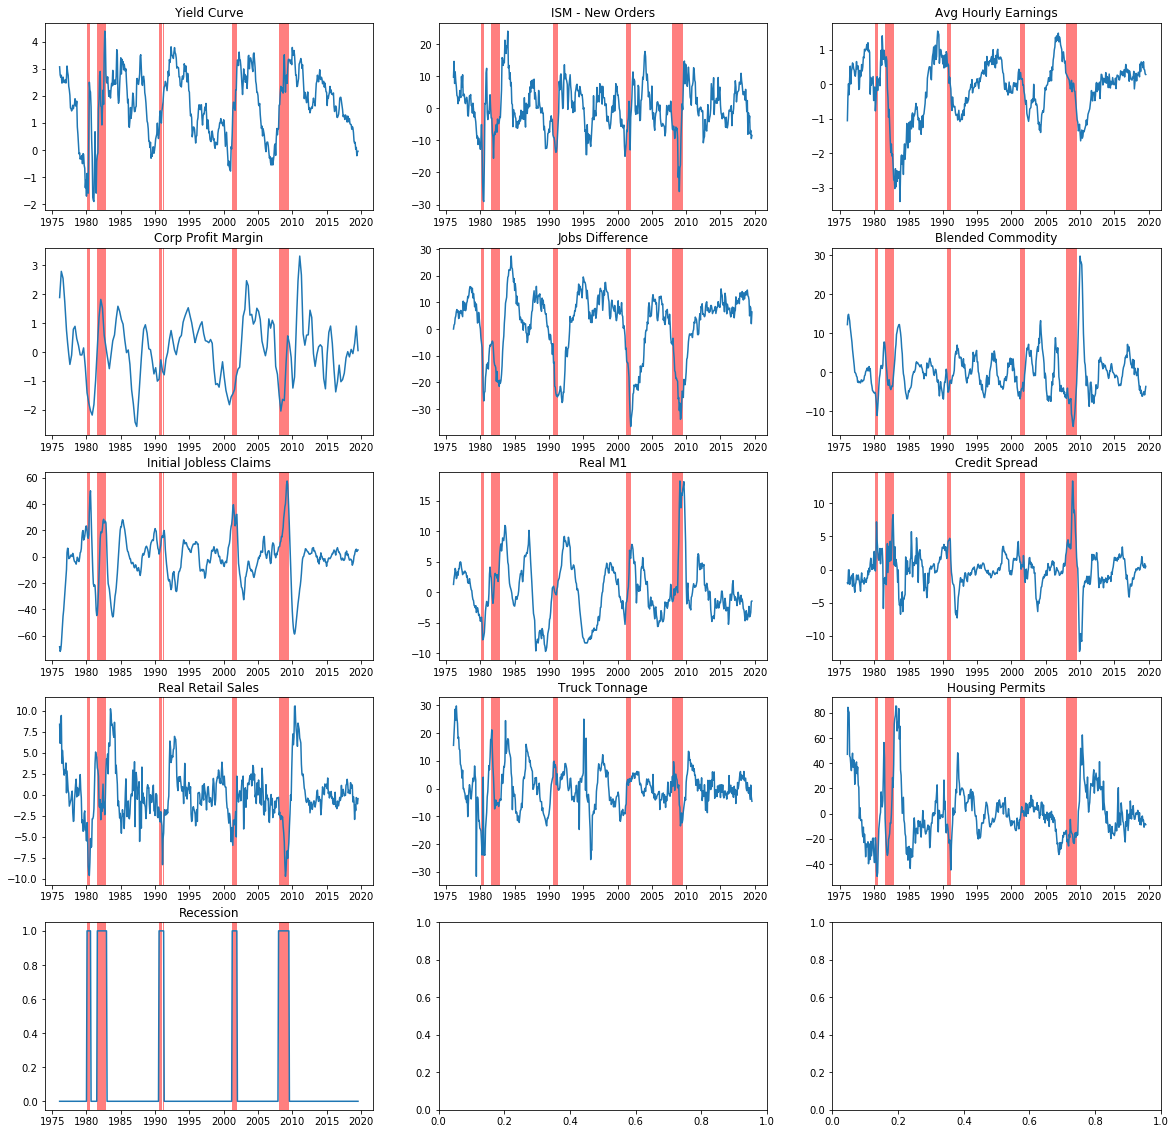

In [6]:
column_num = 3
row_num = 5
fig,axes = plt.subplots(row_num,column_num,figsize=(20,20))
for i,(label,col) in enumerate(df.items()):
    ax = axes[int(i/column_num),i%column_num]
    for j in range(len(recession_date)):
        ax.axvspan(datetime.strptime(recession_date[j][0], '%Y-%m-%d'), datetime.strptime(recession_date[j][1],'%Y-%m-%d'),color='r',alpha=0.5,lw = 0)
    ax.plot(df[label])
    ax.set_title(label)

## Conclusion from the explanatory data analysis
- Some of the indicators have leading changes before the recession starts, few-months leading or a-year leading is possible, so determining the lag months is important to construct the logit model 

# Methodology
## Logit Regression Model
## $Pr(y_{t}) = Pr(\sum _{i}^{_{n}} x_{i_{t-lag\ \ month}}*\beta_{i})$
- $x_{t}$ denote the indicators from the documentations, $\beta_{i}$ denote the regression coefficients for the model
- Pr() is a logit probability model,  $Pr = \frac{1}{1+exp(\sum _{i}^{_{n}} x_{t-lag\ \ month}*\beta_{i})}$
- $y_{t}$ is the dependent variable, 1 denotes the period in recession and 0 as non-recession period

## Lag determination
- Determine the optimal lags for each indicatorn using single logistic regression $Pr(y_{t}) = Pr(x_{t-lag\ \ month}*\beta)$
- Given the nature of the LEIs, here the lag number start from 1 to 24,  e.g 2-lag means using 2 month before data to predict the recession probability this month

In [7]:
def get_lag(columns,lag_range=24):
    """
    columns: pandas.DataFrame columns name (indicator)
    lag_range: list type, the lags range for logit regression
    Return type: the AIC,BIC,R-squared Results
    """
    result_list = []
    for i in range(len(df.columns[:-1])):
        AIC,BIC,Rsquared=[],[],[]
        for j in range(1,lag_range+1):
            y_array = np.array(df['Recession'][j:])
            x_array = np.array(df[df.columns[i]][:len(df)-j])
            logit_model=sm.Logit(y_array,x_array)
            result=logit_model.fit(disp=0)
            AIC.append(result.aic)
            BIC.append(result.bic)
            Rsquared.append(result.prsquared)
        #Use AIC, BIC and pesudo R-squared info to choose the best lag number
        #smaller AIC/BIC, larger R^2, the better
        if np.array(AIC).argmin() == np.array(BIC).argmin() == np.array(Rsquared).argmax():
            lag_list.append((df.columns[i],np.array(AIC).argmin()))
        elif np.array(AIC).argmin() == np.array(BIC).argmin() != np.array(Rsquared).argmax():
            lag_list.append((df.columns[i],np.array(AIC).argmin()))
        elif np.array(AIC).argmin() != np.array(BIC).argmin() == np.array(Rsquared).argmax():
            lag_list.append((df.columns[i],np.array(BIC).argmin()))
        else:
            lag_list.append((df.columns[i],np.array(AIC).argmin()))
    
    return lag_list

In [11]:
lag_list = []
lag_list = get_lag(df,lag_range=24)

In [12]:
lag_list
##Applying the monthly data is not making sense here(?) Since the lag we got here is quite different from the empirical data

[('Yield Curve', 16),
 ('ISM - New Orders', 0),
 ('Avg Hourly Earnings', 17),
 ('Corp Profit Margin', 13),
 ('Jobs Difference', 0),
 ('Blended Commodity', 23),
 ('Initial Jobless Claims', 0),
 ('Real M1', 23),
 ('Credit Spread', 0),
 ('Real Retail Sales', 23),
 ('Truck Tonnage', 22),
 ('Housing Permits', 23)]

In [13]:
## Instead, I choose to determine the lag we should use in our model from the range given in the risk dashboard documentation
#For example, to determine the lag for Yield Curve, it stars from 11 months beofre to 15 months before.
lag_list = [('Yield Curve',[i for i in range(15,10,-1)]),('Credit Spread',[i for i in range(6,1,-1)]),\
            ('Real M1',[i for i in range(13,8,-1)]),('Avg Hourly Earnings',[i for i in range(24,20,-1)]),\
            ( 'Blended Commodity',[i for i in range(6,2,-1)]),('Housing Permits',[i for i in range(7,4,-1)]),\
            ('Initial Jobless Claims',[i for i in range(5,1,-1)]),('Real Retail Sales',[i for i in range(7,4,-1)]),\
            ('Jobs Difference',[i for i in range(11,0,-1)]),('ISM - New Orders',[i for i in range(9,2,-1)]),\
            ('Corp Profit Margin',[i for i in range(17,11,-1)]),('Truck Tonnage',[i for i in range(13,8,-1)])]

In [14]:
## This function is used to find the optimal lags for input indicators
def get_lag_result(df,indicator,lag_range,significance_level=0.05):
    """
    Input:
    df: pandas.DataFrame type
    indicator: string type, name of the risk indicator
    lag_range: list type, list element should be int
    Return Type:
    list type, each tuple contains the p-value below the significance level
    and accordingly the lag period 
    """
    data_list = []
    for i in range(len(lag_range)):
        data_list.append(df[indicator][i:-lag_range[i]].values)
    df_new = pd.DataFrame(data=data_list).T
    logit = sm.Logit(df['Recession'][lag_range[0]:].values, df_new[df_new.columns])
    result=logit.fit(disp=0)
    p_values = result.pvalues
    lag_result = []
    for i in range(len(p_values)):
        if p_values[i] < significance_level:
            lag_result.append((p_values[i],lag_range[i]))
    return lag_result

In [15]:
#Test this function
lag_result = [(lag_list[i][0],get_lag_result(df,lag_list[i][0],lag_list[i][1],significance_level=0.1)) for i in range(len(lag_list))]

In [16]:
lag_result

[('Yield Curve', [(0.0005568300067355389, 15), (0.07543948925362937, 11)]),
 ('Credit Spread', [(0.001442255412100606, 2)]),
 ('Real M1', []),
 ('Avg Hourly Earnings', [(0.09934657541735661, 21)]),
 ('Blended Commodity', []),
 ('Housing Permits', []),
 ('Initial Jobless Claims', [(0.0019943428288397205, 2)]),
 ('Real Retail Sales', []),
 ('Jobs Difference', [(2.745335754124083e-05, 1)]),
 ('ISM - New Orders', [(0.019844272466477776, 3)]),
 ('Corp Profit Margin', []),
 ('Truck Tonnage', [(0.08633149176716552, 13)])]

## Result from the lag determination. 
- We could see the lags for yield curve, for example, is 15 and 11, which indicates that we should incorporate the 11 months and 15 months lags for yield curve, because these are statistically significant (95% confidence level)
- For these indicators that does not have a good lag, I choose the lag month that indicates a yellow signal from the risk dashboard documentation.

# Train the model
## From the results above, I determine to use the following logit model to predict:
### $Pr(y_{t}) = Pr(x_{yield\ \ curve_{t-15}}*\beta_{1}+x_{yield\ \ curve_{t-11}}*\beta_{2}+x_{credit\ \ spread_{t-2}}*\beta_{3}+x_{Real\ \ M1_{t-13}}*\beta_{4}+x_{Avg\ \ Hourly\ \ Earnings_{t-21}}*\beta_{5}+x_{Blended\ \ Commodity_{t-7}}*\beta_{6}+x_{Housing\ \ Permits_{t-8}}*\beta_{7}+x_{Initial\ \ Jobless\ \ Claims_{t-2}}*\beta_{8}+x_{Real\ \ Retail\ \ Sales_{t-8}}*\beta_{9}+x_{Jobs\ \ Difference_{t-1}}*\beta_{10}+x_{ISM\ \ New\ \ Orders_{t-3}}*\beta_{11}+x_{Corp\ \ Profit\ \ Margin_{t-19}}*\beta_{12}+x_{Truck\ \ Tonnage_{t-13}}*\beta_{13})$

In [17]:
#Split 60% of the data as train-set and 40% of the data as test-set
train_set = df[:int(len(df)*0.6)]
test_set = df[int(len(df)*0.4):]

In [18]:
max_lag = 21

In [19]:
y_array = train_set['Recession'][21:].values

In [20]:
# logit_lag_list = [15,2,13,21,7,8,2,8,1,3,18,13]

In [21]:
#Here build a dataframe using the lags from determination part and documentation
data = [train_set['Yield Curve'][max_lag-15:max_lag-15+len(y_array)].values,\
        train_set['Yield Curve'][max_lag-11:max_lag-11+len(y_array)].values,
        train_set['Credit Spread'][max_lag-2:max_lag-2+len(y_array)].values,\
        train_set['Real M1'][max_lag-13:max_lag-13+len(y_array)].values,\
        train_set['Avg Hourly Earnings'][:-max_lag].values,\
        train_set['Blended Commodity'][max_lag-7:max_lag-7+len(y_array)].values,\
        train_set['Housing Permits'][max_lag-8:max_lag-8+len(y_array)].values,\
        train_set['Initial Jobless Claims'][max_lag-2:max_lag-2+len(y_array)].values,\
        train_set['Real Retail Sales'][max_lag-8:max_lag-8+len(y_array)].values,\
        train_set['Jobs Difference'][max_lag-1:max_lag-1+len(y_array)].values,\
        train_set['ISM - New Orders'][max_lag-3:max_lag-3+len(y_array)].values,\
        train_set['Corp Profit Margin'][max_lag-18:max_lag-18+len(y_array)].values,\
        train_set['Truck Tonnage'][max_lag-13:max_lag-13+len(y_array)].values]

In [22]:
df_train = pd.DataFrame(data=data).T

In [23]:
logit = sm.Logit(y_array,df_train[df_train.columns])
result=logit.fit(disp=0)

In [24]:
print(result.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.593     
Dependent Variable: y                AIC:              123.8530  
Date:               2019-08-19 11:51 BIC:              171.6508  
No. Observations:   292              Log-Likelihood:   -48.927   
Df Model:           12               LL-Null:          -120.26   
Df Residuals:       279              LLR p-value:      1.7247e-24
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     9.0000                                       
--------------------------------------------------------------------
       Coef.     Std.Err.       z       P>|z|      [0.025     0.975]
--------------------------------------------------------------------
0     -1.0387      0.3324    -3.1251    0.0018    -1.6902    -0.3873
1     -1.7251      0.3862    -4.4668    0.0000    -2.4820    -0.9681
2      0.4822      0.1576     3.0588    0.0022     0.1732     0.7912
3     -0.2474     

## Regression Summary
- The coefficients for some of the variables are statistically significant, like yield curve, real M1, average hourly earnings, blended commidity, corporate profit margin, Jobs Difference. (Given the 90% confidence level (see the P>|z|), if p-values are less then 0.1, we could say that these variables are statistically significant).
- The rest coefficients are not statistically significant, especially the initial jobless claims, real retails slaes and truck tonnage. (I think it is because the lag we choose here determines the robustness of these indicators）

# Out-of-sample Test

In [25]:
#The target y-values for the test set
y_test = test_set['Recession'][21:].values

In [26]:
#Construct the test dataframe
test_data = data = [test_set['Yield Curve'][max_lag-15:max_lag-15+len(y_test)].values,\
                    test_set['Yield Curve'][max_lag-11:max_lag-11+len(y_test)].values,\
        test_set['Credit Spread'][max_lag-2:max_lag-2+len(y_test)].values,\
        test_set['Real M1'][max_lag-13:max_lag-13+len(y_test)].values,\
        test_set['Avg Hourly Earnings'][:-max_lag].values,\
        test_set['Blended Commodity'][max_lag-7:max_lag-7+len(y_test)].values,\
        test_set['Housing Permits'][max_lag-8:max_lag-8+len(y_test)].values,\
        test_set['Initial Jobless Claims'][max_lag-2:max_lag-2+len(y_test)].values,\
        test_set['Real Retail Sales'][max_lag-8:max_lag-8+len(y_test)].values,\
        test_set['Jobs Difference'][max_lag-1:max_lag-1+len(y_test)].values,\
        test_set['ISM - New Orders'][max_lag-3:max_lag-3+len(y_test)].values,\
        test_set['Corp Profit Margin'][max_lag-18:max_lag-18+len(y_test)].values,\
        test_set['Truck Tonnage'][max_lag-13:max_lag-13+len(y_test)].values]
df_test = pd.DataFrame(data = test_data).T

In [27]:
#Get the predicted value for the out-of-sample test
predict_result = []
for i in range(len(df_test)):
    predict_result.append(1/(1+np.exp(-sum(df_test.iloc[i]*result.params))))

In [28]:
#Get the true positive rate, false positive rate from out-of-sample testing
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, predict_result, pos_label=1)

In [29]:
auc = metrics.roc_auc_score(y_test, predict_result)

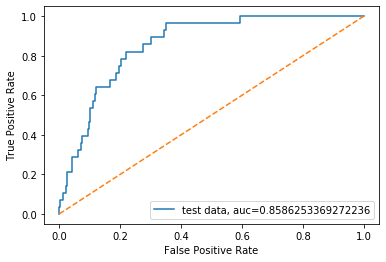

In [30]:
#Draw the area-under-curve(AUC) graph
plt.plot(fpr,tpr,label='test data, auc='+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()
plt.show()

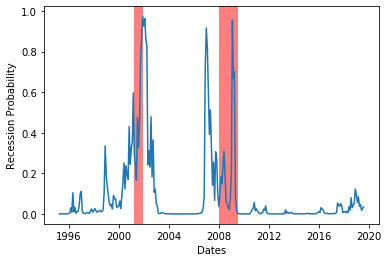

In [31]:
test_recession_date = [('2001-03-31','2001-11-30'),('2007-12-31','2009-06-30')]
for j in range(len(test_recession_date)):
    plt.axvspan(datetime.strptime(test_recession_date[j][0], '%Y-%m-%d'), datetime.strptime(test_recession_date[j][1],'%Y-%m-%d'),color='r',alpha=0.5,lw = 0)
plt.ylabel('Recession Probability')
plt.xlabel('Dates')
plt.plot(test_set['Recession'][21:].index,predict_result)
plt.show()

## Conclusion from the out-of-sample test
- The Area under curve (AUC) is 0.86 and close to 1, which means this model has a good predict ability in recession.
- From the graph we could see, before and during the recession period, we could see the predicted porbility from the model are increasing sharply.